In [451]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from nescient.utils.TSMetric import TSMetric
plt.style.use('default')

normal_packets_count = pd.read_csv('csv_datasets/normal/packets.csv')
normal_unique_source_count = pd.read_csv('csv_datasets/normal/USIP.csv')
normal_unique_destination_count = pd.read_csv('csv_datasets/normal/UDIP.csv')
normal_unique_protocol_count = pd.read_csv('csv_datasets/normal/UPR.csv')
normal_real = pd.read_csv('csv_datasets/normal/real.csv')
normal_A1_all = normal_packets_count.iloc[:, 1].to_frame()
normal_A2_all = normal_unique_source_count.iloc[:, 1].to_frame()
normal_A3_all = normal_unique_source_count.iloc[:, 1].divide(normal_unique_destination_count.iloc[:, 1]).to_frame()
normal_A4_all = normal_unique_source_count.iloc[:, 1].divide(normal_unique_protocol_count.iloc[:, 1]).to_frame()
normal_A_all = (normal_A1_all, normal_A2_all, normal_A3_all, normal_A4_all)

dos_packets_count = pd.read_csv('csv_datasets/dos/packets.csv')
dos_unique_source_count = pd.read_csv('csv_datasets/dos/USIP.csv')
dos_unique_destination_count = pd.read_csv('csv_datasets/dos/UDIP.csv')
dos_unique_protocol_count = pd.read_csv('csv_datasets/dos/UPR.csv')
dos_real = pd.read_csv('csv_datasets/dos/real.csv')
dos_A1_all = dos_packets_count.iloc[:, 1].to_frame()
dos_A2_all = dos_unique_source_count.iloc[:, 1].to_frame()
dos_A3_all = dos_unique_source_count.iloc[:, 1].divide(dos_unique_destination_count.iloc[:, 1]).to_frame()
dos_A4_all = dos_unique_source_count.iloc[:, 1].divide(dos_unique_protocol_count.iloc[:, 1]).to_frame()
dos_A_all = (dos_A1_all, dos_A2_all, dos_A3_all, dos_A4_all)

spoofed_dos_packets_count = pd.read_csv('csv_datasets/spoofed_dos/packets.csv')
spoofed_dos_packets_count["T"] = pd.to_timedelta(spoofed_dos_packets_count.time)
spoofed_dos_packets_count = spoofed_dos_packets_count.set_index("T")
spoofed_dos_unique_source_count = pd.read_csv('csv_datasets/spoofed_dos/USIP.csv')
spoofed_dos_unique_source_count["T"] = pd.to_timedelta(spoofed_dos_unique_source_count.time)
spoofed_dos_unique_source_count = spoofed_dos_unique_source_count.set_index("T")
spoofed_dos_unique_destination_count = pd.read_csv('csv_datasets/spoofed_dos/UDIP.csv')
spoofed_dos_unique_destination_count["T"] = pd.to_timedelta(spoofed_dos_unique_destination_count.time)
spoofed_dos_unique_destination_count = spoofed_dos_unique_destination_count.set_index("T")
spoofed_dos_unique_protocol_count = pd.read_csv('csv_datasets/spoofed_dos/UPR.csv')
spoofed_dos_unique_protocol_count["T"] = pd.to_timedelta(spoofed_dos_unique_protocol_count.time)
spoofed_dos_unique_protocol_count = spoofed_dos_unique_protocol_count.set_index("T")

spoofed_dos_real = pd.read_csv('csv_datasets/spoofed_dos/real.csv')
spoofed_dos_A1_all = spoofed_dos_packets_count.iloc[:, 1].to_frame()
spoofed_dos_A2_all = spoofed_dos_unique_source_count.iloc[:, 1].to_frame()
spoofed_dos_A3_all = spoofed_dos_unique_source_count.iloc[:, 1].divide(spoofed_dos_unique_destination_count.iloc[:, 1]).to_frame()
spoofed_dos_A4_all = spoofed_dos_unique_source_count.iloc[:, 1].divide(spoofed_dos_unique_protocol_count.iloc[:, 1]).to_frame()
spoofed_dos_A_all = (spoofed_dos_A1_all, spoofed_dos_A2_all, spoofed_dos_A3_all, spoofed_dos_A4_all)

In [452]:
# Change below variable to switch scenario
A_all_to_be_used = spoofed_dos_A_all
real_to_be_used = spoofed_dos_real


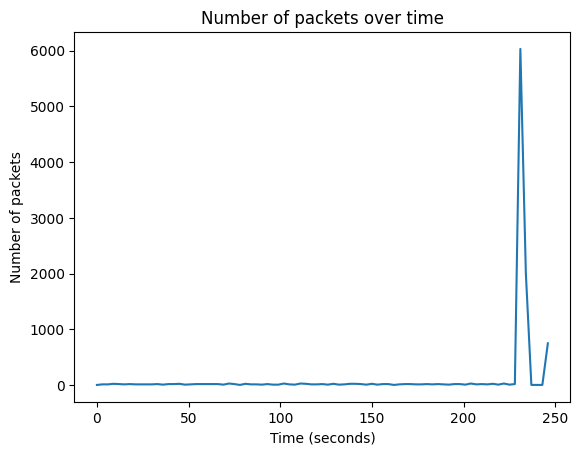

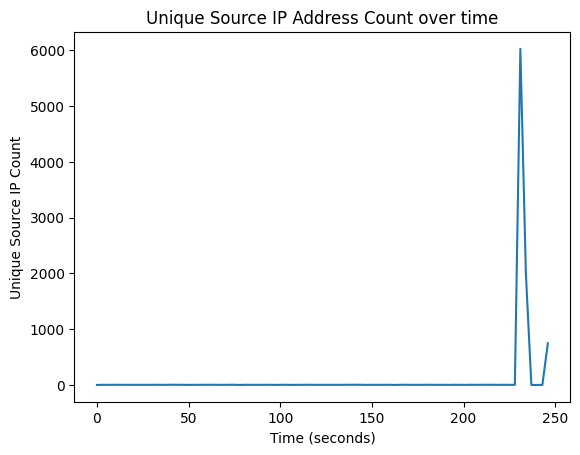

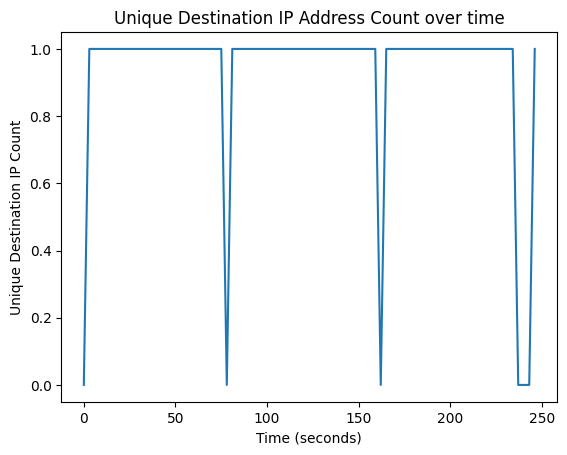

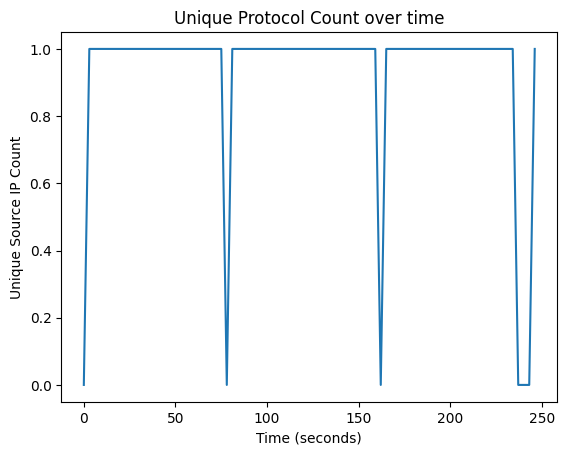

In [453]:
def normalize_time(times, reducer):
    return [time_sec - reducer for time_sec in times]

plt.plot(normalize_time(spoofed_dos_packets_count.index.seconds, 77343), spoofed_dos_packets_count.Packets)
plt.title("Number of packets over time")
plt.xlabel("Time (seconds)")
plt.ylabel("Number of packets")
plt.savefig("plots/packets.png")
plt.show()

plt.plot(normalize_time(spoofed_dos_packets_count.index.seconds, 77343), spoofed_dos_unique_source_count.USIP)
plt.title("Unique Source IP Address Count over time")
plt.xlabel("Time (seconds)")
plt.ylabel("Unique Source IP Count")
plt.savefig("plots/usip.png")
plt.show()

plt.plot(normalize_time(spoofed_dos_packets_count.index.seconds, 77343), spoofed_dos_unique_destination_count.UDIP)
plt.title("Unique Destination IP Address Count over time")
plt.xlabel("Time (seconds)")
plt.ylabel("Unique Destination IP Count")
plt.savefig("plots/udip.png")
plt.show()

plt.plot(normalize_time(spoofed_dos_packets_count.index.seconds, 77343), spoofed_dos_unique_protocol_count.UPR)
plt.title("Unique Protocol Count over time")
plt.xlabel("Time (seconds)")
plt.ylabel("Unique Source IP Count")
plt.savefig("plots/upr.png")
plt.show()

In [454]:
A_all = A_all_to_be_used
Threshold_all = []
N_all = []
beta_all = []

for A in A_all:
    # Init values
    K = 1
    beta = 1.5
    j = 0
    T = 3
    current_threshold_array = list()
    current_N_array = list()
    current_beta_array = list()

    A_list = A.iloc[:, 0].to_list()
    safe_A_list = [*A_list, *([0] * K * T)]

    current_moving_A = A.iloc[j: j+K, 0].to_list()
    current_moving_mean = np.mean(current_moving_A)
    current_moving_variance = np.std(current_moving_A)
    current_threshold = (current_moving_mean + current_moving_variance) * beta

    current_threshold_array.append([j, current_threshold])
    current_beta_array.append([j, beta])

    # while j <= K*T-1 and j < len(A1_all.iloc[:, 0].to_list()):
    while j < len(A_list):
        if j < 0 and j % K*T == 0:
            beta = 1.5
            current_moving_A = safe_A_list[j: j+K]
            current_moving_mean = np.mean(current_moving_A)
            current_moving_variance = np.std(current_moving_A)
            current_threshold = (current_moving_mean + current_moving_variance) * beta

            current_threshold_array.append([j, current_threshold])
            current_beta_array.append([j, beta])
            if safe_A_list[j:j+1][0] > current_threshold:
                current_N_array.append([j, True])
            else:
                current_N_array.append([j, False])
        else:
            if safe_A_list[j:j+1][0] > current_threshold:
                current_N_array.append([j, True])
            else:
                current_N_array.append([j, False])
            j = j + 1
            current_j = j
            previous_j = j - 1
            previous_moving_mean = np.mean(safe_A_list[previous_j: previous_j+K])
            current_moving_mean = np.mean(safe_A_list[current_j: current_j+K])
            if current_moving_mean > 2 * previous_moving_mean:
                beta = beta + 0.5
                current_threshold = (current_moving_mean + np.std(safe_A_list[current_j: current_j+K])) / beta
            else:
                beta = beta - 0.5
                if beta < 1.0:
                    beta = 1
                current_threshold = (current_moving_mean + np.std(safe_A_list[current_j: current_j+K])) * beta
            current_threshold_array.append([current_j, current_threshold])
            current_beta_array.append([j, beta])

    Threshold_all.append(current_threshold_array)
    N_all.append(current_N_array)
    beta_all.append(current_beta_array)

In [455]:
j_to_end = range(len(A_all_to_be_used[0].iloc[:, 0].to_list()))

N_for_testing = []

for idx in j_to_end:
    if N_all[0][idx][1] is True and N_all[1][idx][1] is True and N_all[2][idx][1] is True and N_all[3][idx][1] is True:
        N_for_testing.append(1)
    else:
        N_for_testing.append(0)

In [456]:
y_real = real_to_be_used.iloc[:, 1].to_list()

In [457]:
y_pred = N_for_testing




In [458]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return TP, FP, TN, FN

def sensitivity(true_positive, false_negative):
    return true_positive / (true_positive + false_negative)

def accuracy(true_positive, false_positive, true_negative, false_negative):
    return (true_positive + true_negative) / (true_positive + false_positive + true_negative + false_negative)

def specificity(true_negative, false_positive):
    return true_negative / (true_negative + false_positive)

def precision(true_positive, false_positive):
    return true_positive / (true_positive + false_positive)

In [459]:
tp, fp, tn, fn = perf_measure(y_real, y_pred)
print(
    "\ntrue positive: {}".format(tp),
    "\nfalse positive: {}".format(fp),
    "\ntrue negative: {}".format(tn),
    "\nfalse negative: {}".format(fn)
)

print("\n")

print("Sensitivity (TPR): {}".format(sensitivity(tp, fn)))
print("Accuracy: {}".format(accuracy(tp, fp, tn, fn)))
print("Specificity (TNR): {}".format(specificity(tn, fp)))
print("Precision: {}".format(precision(tp, fp)))


true positive: 1 
false positive: 8 
true negative: 73 
false negative: 1


Sensitivity (TPR): 0.5
Accuracy: 0.891566265060241
Specificity (TNR): 0.9012345679012346
Precision: 0.1111111111111111


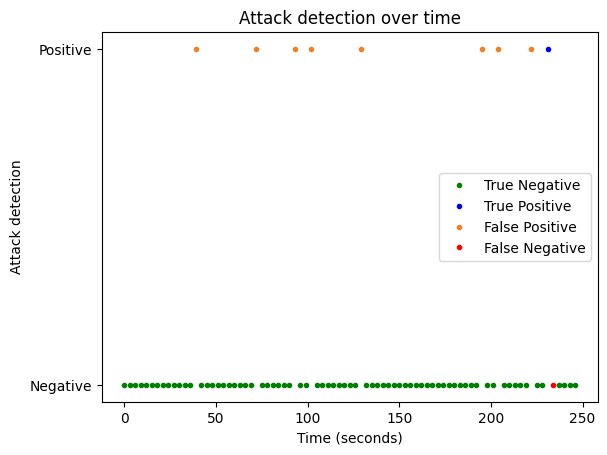

In [460]:
# tp, fp, fn
def generate_score_visual(y_actual, y_hat):
    tp_list = [None] * len(y_hat)
    fp_list = [None] * len(y_hat)
    tn_list = [None] * len(y_hat)
    fn_list = [None] * len(y_hat)

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           tp_list[i] = 1
        elif y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           fp_list[i] = 1
        elif y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           fn_list[i] = 0
        elif y_actual[i]==y_hat[i]==0:
            tn_list[i] = 0
    return tp_list, fp_list, tn_list, fn_list

tpl, fpl, tnl, fnl = generate_score_visual(y_real, y_pred)

plt.title("Attack detection over time")
plt.xlabel("Time (seconds)")
plt.ylabel("Attack detection")
plt.yticks([1.0, 0.0], ["Positive", "Negative"])
plt.plot(normalize_time(spoofed_dos_packets_count.index.seconds, 77343), tnl, 'g.', label='True Negative')
plt.plot(normalize_time(spoofed_dos_packets_count.index.seconds, 77343), tpl, 'b.', label='True Positive')
plt.plot(normalize_time(spoofed_dos_packets_count.index.seconds, 77343), fpl, '#F48024', marker='.', linestyle='', label='False Positive')
plt.plot(normalize_time(spoofed_dos_packets_count.index.seconds, 77343), fnl, 'r.', label='False Negative')
plt.legend()
plt.savefig('plots/score_visual.png')
plt.show()

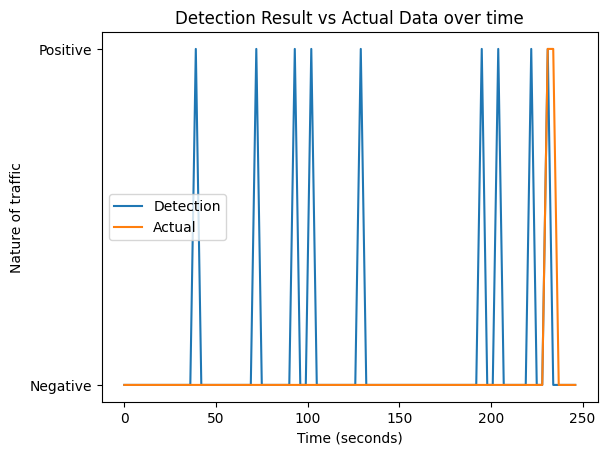

In [461]:
plt.title("Detection Result vs Actual Data over time")
plt.xlabel("Time (seconds)")
plt.ylabel("Nature of traffic")
plt.yticks([1.0, 0.0], ["Positive", "Negative"])
plt.plot(normalize_time(spoofed_dos_packets_count.index.seconds, 77343), y_pred, label='Detection')
plt.plot(normalize_time(spoofed_dos_packets_count.index.seconds, 77343), y_real, label='Actual')
plt.legend()
plt.savefig('plots/detection_vs_actual.png')
plt.show()